# Fine-Tuning CLIP for Swahili Semantic Video Search

## Introduction

The growing adoption of artificial intelligence (AI) in language processing has largely focused on high-resource languages, leaving underrepresented languages like Swahili with limited support. This research addresses this gap by fine-tuning the pre-trained Contrastive Language-Image Pretraining (CLIP) model to handle Swahili queries effectively. Leveraging transfer learning, the study adapts the model to understand and generate meaningful responses to Swahili text. By utilizing a specialized dataset of Swahili text-image pairs, the fine-tuned model is trained to capture the contextual and semantic intricacies of the Swahili language.

The primary objective is to develop a robust system capable of performing semantic video searches based on Swahili queries. This advancement aims to enhance accessibility and usability for Swahili-speaking users, fostering inclusivity in AI technologies. Beyond semantic search, the outcomes of this research hold potential applications across education, media, and information retrieval, bridging the language barrier in AI-powered solutions and making such technologies more accessible to diverse linguistic communities.


In [ ]:
# !pip install torch torchvision transformers pillow tqdm sentencepiece

In [21]:
import os
import json
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import MarianMTModel, MarianTokenizer
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizer, XLMRobertaModel, XLMRobertaTokenizer,AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
from torch.nn import CrossEntropyLoss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
import pandas as pd
import re
from safetensors.torch import load_file


sns.set(style="darkgrid")

os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["CUDA_MODULE_LOADING"] = "LAZY"

if torch.cuda.is_available():
    torch.cuda.empty_cache()

## Data Loader

### Dataset Summary

This research uses the Swahili scene text detection dataset, consisting of 976 natural scene images annotated at the word level. The dataset captures various real-world environments, such as urban settings and public signage, where Swahili text is commonly found. It reflects the linguistic and cultural diversity of Swahili speakers. The datwasis sourced from the puicbl [GitHub repositorye ry, which includes both images and annotatin
.

The dataset is split into training (700 images) and testing (276 images) sets, ensuring effective model training and evalun

atio### Overview of `SwahiliDataset` Class

The `SwahiliDataset` class is a custom PyTorch dataset designed to handle Swahili text-image pairs for training multimodal models. It loads data from a JSON file containing image paths and associated Swahili text, processes the images and text, and provides functionality for dataset exploration and visualizati
n.

#### Key Features:
- **Text Preprocessing**: Cleans and processes Swahili text by removing special characters and extra spaces.
- **Data Loading**: Efficiently loads and prepares text and image pairs for model input.
- **Dataset Description**: Provides a summary of dataset statistics including number of items, unique images, and text lengths.
- **Visualization**: Displays random samples of image-text pairs to aid in data inn.rocessing.


In [3]:
class SwahiliDataset(Dataset):
    def __init__(self, json_path, image_folder, processor):
        with open(json_path, 'r') as f:
            self.data = json.load(f)["data_list"]
        self.image_folder = image_folder
        self.processor = processor
    
    def __len__(self):
        return len(self.data)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text) ## Remove special characters
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
        return text
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['img_path']
        text = " ".join([instance["text"] for instance in item["instances"]])
        text = self.clean_text(text)
        
        full_image_path = os.path.join(self.image_folder, image_path)
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image file not found: {full_image_path}")
        
        image = Image.open(full_image_path).convert("RGB")
        
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True)
        
        return text, inputs['input_ids'][0], inputs['pixel_values'][0]
     ## Function to describe the data
    
    def describe(self):
        num_items = len(self.data)

        first_text_input, input_ids, pixel_values = self.__getitem__(0)

        text_shape = input_ids.shape  # Shape of the input_ids tensor
        image_shape = pixel_values.shape  # Shape of the pixel_values tensor

        text_lengths = [len(" ".join([instance["text"] for instance in item["instances"]]).split()) for item in self.data]
        avg_text_length = np.mean(text_lengths)

        unique_images = set(item['img_path'] for item in self.data)
        num_unique_images = len(unique_images)

        unique_texts = set(" ".join([instance["text"] for instance in item["instances"]]) for item in self.data)
        num_unique_texts = len(unique_texts)

        image_dims = [Image.open(os.path.join(self.image_folder, item['img_path'])).size for item in self.data]
        image_dims_counter = Counter(image_dims)

        sample_texts = [item["instances"][0]["text"] for item in self.data[:5]]

        missing_images = [item['img_path'] for item in self.data if not os.path.exists(os.path.join(self.image_folder, item['img_path']))]
        num_missing_images = len(missing_images)

        description = {
            "Number of items": num_items,
            "Text input shape": text_shape,
            "Image input shape": image_shape,
            "Average text length": avg_text_length,
            "Number of unique images": num_unique_images,
            "Number of unique texts": num_unique_texts,
            "Sample texts": sample_texts,
            "Number of missing images": num_missing_images,
        }

        return description
    
    def plot_sample(self, num_samples=5):
        """Plot a sample of image-text pairs using Seaborn's aesthetics with Matplotlib."""
        sns.set(style="whitegrid")
        indices = np.random.choice(len(self.data), num_samples, replace=False)
        
        plt.figure(figsize=(15, num_samples * 5))
        for i, idx in enumerate(indices):
            item = self.data[idx]
            image_path = item['img_path']
            text = " ".join([instance["text"] for instance in item["instances"]])
            full_image_path = os.path.join(self.image_folder, image_path)
            image = Image.open(full_image_path)
            
            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(image)  # Use Matplotlib's imshow to display the image
            plt.title(text, fontsize=14)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


In [4]:
"""
This function ensures that the data is correctly formatted and ready for processing during training or 
evaluation.
"""
def collate_fn(batch):
    texts, input_ids, pixel_values = zip(*batch) 
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=0)
    pixel_values = torch.stack(pixel_values)
    return input_ids, pixel_values


### Data Augmentation with Translation

Initial
The Flickr30k dataset was used to augment the Swahili scene text detection dataset. The dataset consists of more than **31,000 images** sourced from Flickr, each paired with **five descriptive captions** written in English. These captions provide detailed natural language descriptions of the visual content, enabling models to learn the association between images and text.

English comments from the `flickr30k_images` were translated into Kiswahili using the `Helsinki-NLP/opus-mt-en-sw` MarianMT model.  The `translate_to_swahili` function tokenizes the English text, generates the Kiswahili translation, and decodes it into readable text.


In [ ]:
flickr30 = pd.read_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv', delimiter='|')

model_name = 'Helsinki-NLP/opus-mt-en-sw'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_to_swahili(text):
    translated = model.generate(**tokenizer(text, return_tensors="pt", padding=True))
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Translate comments
flickr30['comment_sw'] = flickr30[' comment'].apply(translate_to_swahili)
flickr30.to_csv('/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_translated.csv', index=False)


In [5]:
class NewSwahiliDataset(Dataset):
    def __init__(self, csv_path, image_folder, processor):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.processor = processor
    
    def __len__(self):
        return len(self.data)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_name = item['image_name']
        text = item['comment_sw']
        text = self.clean_text(text)
        
        full_image_path = os.path.join(self.image_folder, image_name)
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image file not found: {full_image_path}")
        
        image = Image.open(full_image_path).convert("RGB")
        
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True)
        
        return text, inputs['input_ids'][0], inputs['pixel_values'][0]
    
    def describe(self):
        num_items = len(self.data)
        
        # Example of first item in the dataset
        first_text_input, input_ids, pixel_values = self.__getitem__(0)
        text_shape = input_ids.shape
        image_shape = pixel_values.shape
        
        # Calculate average text length
        text_lengths = [len(item.split()) for item in self.data['comment_sw']]
        avg_text_length = np.mean(text_lengths)
        
        # Count unique images and texts
        num_unique_images = self.data['image_name'].nunique()
        num_unique_texts = self.data['comment_sw'].nunique()
        
        # Image dimensions
        image_dims = [Image.open(os.path.join(self.image_folder, img_name)).size for img_name in self.data['image_name']]
        image_dims_counter = Counter(image_dims)
        
        # Sample texts
        sample_texts = self.data['comment_sw'].head(5).tolist()
        
        # Missing images
        missing_images = [img_name for img_name in self.data['image_name'] if not os.path.exists(os.path.join(self.image_folder, img_name))]
        num_missing_images = len(missing_images)
        
        description = {
            "Number of items": num_items,
            "Text input shape": text_shape,
            "Image input shape": image_shape,
            "Average text length": avg_text_length,
            "Number of unique images": num_unique_images,
            "Number of unique texts": num_unique_texts,
            "Sample texts": sample_texts,
            "Number of missing images": num_missing_images,
            "Image dimensions frequency": image_dims_counter,
        }
        
        return description
    
    def plot_sample(self, num_samples=5):
        sns.set(style="whitegrid")
        indices = np.random.choice(len(self.data), num_samples, replace=False)
        
        plt.figure(figsize=(15, num_samples * 5))
        for i, idx in enumerate(indices):
            item = self.data.iloc[idx]
            image_name = item['image_name']
            text = item['comment_sw']
            full_image_path = os.path.join(self.image_folder, image_name)
            image = Image.open(full_image_path)
            
            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(image)  
            plt.title(text, fontsize=14)
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


## Data Loading


Thisectionde prepares datasets for fine-tunita. It combines two datasets: the original Swahili dataset and a translated Flickr30K dataset, creating a diverse training and testing set. The datasets are preprocessed using a `CLIPProcessor` and loaded into `DataLoader` instances for efficient batching and shuffling during training and evaluation.


In [6]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Create datasets and dataloaders
original_train_dataset = SwahiliDataset('/kaggle/input/swahilidata/swahili/train/train.json', 
                               '/kaggle/input/swahilidata/swahili/train/train_imgs',
                               processor)

new_train_dataset = NewSwahiliDataset(
    '/kaggle/input/flick30-swahili/Flick30_translated/flickr30_translated_train.csv',
    '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images',
    processor
)

# Combine datasets
combined_train_dataset = ConcatDataset([original_train_dataset, new_train_dataset])

train_dataloader = DataLoader(combined_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn, num_workers=2, drop_last=True)

original_test_dataset = SwahiliDataset('/kaggle/input/swahilidata/swahili/test/test.json', 
                              '/kaggle/input/swahilidata/swahili/test/test_imgs',
                              processor)

new_test_dataset = NewSwahiliDataset(
    '/kaggle/input/flick30-swahili/Flick30_translated/flickr30_translated_test.csv',
    '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images',
    processor
)

combined_test_dataset = ConcatDataset([original_test_dataset, new_test_dataset])

test_dataloader = DataLoader(combined_test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn, num_workers=2, drop_last=True)

2024-11-25 18:27:58.314903: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-25 18:27:58.315018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-25 18:27:58.444243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [ ]:
print('Original Train Dataset')
original_train_desc = original_train_dataset.describe()
original_train_df = pd.DataFrame([original_train_desc])
print(original_train_df.T)

print('New Train Dataset')
new_train_desc = new_train_dataset.describe()
new_train_df = pd.DataFrame([new_train_desc])
print(new_train_df.T)

print('Original Test Dataset')
original_test_desc = original_test_dataset.describe()
original_test_df = pd.DataFrame([original_test_desc])
print(original_train_df.T)

print('New Test Dataset')
new_test_desc = new_test_dataset.describe()
new_test_df = pd.DataFrame([new_test_desc])
print(new_train_df.T)

In [ ]:
original_train_dataset.plot_sample()
new_train_dataset.plot_sample()

## CLIP Fine Tuned

In [ ]:
# Initialize the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use Data Parallelism if multiple GPUs are available
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

# Training settings
optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 5

# Checkpoint directory and file
checkpoint_dir = "/kaggle/working/checkpoints"
checkpoint_file = os.path.join(checkpoint_dir, "clip_model_checkpoint.pth")
os.makedirs(checkpoint_dir, exist_ok=True)

# Load checkpoint if it exists
start_epoch = 0
train_losses = []
test_losses = []
if os.path.isfile(checkpoint_file):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']
    print(f"Resuming training from epoch {start_epoch}")

# Training loop
try:
    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids, pixel_values = batch
            input_ids = input_ids.to(device)
            pixel_values = pixel_values.to(device)

            optimizer.zero_grad()

            outputs = model(input_ids=input_ids, pixel_values=pixel_values)

            # Calculate the loss
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text

            num_classes = logits_per_image.size(1)  # This should be 16 based on the model output
            labels = torch.arange(len(logits_per_image)) % num_classes  # Ensure labels are within range
            labels = labels.to(device)

            loss_image = F.cross_entropy(logits_per_image, labels)
            loss_text = F.cross_entropy(logits_per_text, labels)
            loss = (loss_image + loss_text) / 2

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Train Loss: {avg_loss:.4f}")

        # Evaluation on test set
        model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            total_samples = 0
            for batch in tqdm(test_dataloader, desc="Evaluating"):
                input_ids, pixel_values = batch
                input_ids = input_ids.to(device)
                pixel_values = pixel_values.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values)

                logits_per_image = outputs.logits_per_image
                logits_per_text = outputs.logits_per_text

                labels = torch.arange(len(logits_per_image)) % logits_per_image.size(1)
                labels = labels.to(device)

                loss_image = F.cross_entropy(logits_per_image, labels)
                loss_text = F.cross_entropy(logits_per_text, labels)
                loss = (loss_image + loss_text) / 2

                test_loss += loss.item()

                # Calculate accuracy
                pred = torch.argmax(logits_per_image, dim=1)
                correct += (pred == labels).sum().item()
                total += len(labels)
                total_samples += len(labels)

            if total_samples == 0:
                print("Warning: No samples processed in the evaluation loop. Check your DataLoader.")
            else:
                avg_test_loss = test_loss / len(test_dataloader)
                test_losses.append(avg_test_loss)
                accuracy = correct / total
                print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Save checkpoint at the end of each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses
        }, checkpoint_file)
        print(f"Checkpoint saved for epoch {epoch + 1}")

except Exception as e:
    print(f"An error occurred during training: {str(e)}")

# Save the fine-tuned model
model.module.save_pretrained("/kaggle/working/fine-tuned-clip-swahili") if torch.cuda.device_count() > 1 else model.save_pretrained("/kaggle/working/fine-tuned-clip-swahili")


## Training process with 5 epochs takes approximately 3 hours to train on GPU T4 x2 with 16GB RAM each.

In [ ]:
# Plot the training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

## Evaluate Model

In [7]:
def evaluate_model(model, dataloader, is_custom_model=False):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, total=len(dataloader)):
            input_ids, pixel_values = batch
            input_ids = input_ids.to(device)
            pixel_values = pixel_values.to(device)
            
            if is_custom_model:
                logits_per_image, _ = model(input_ids=input_ids, pixel_values=pixel_values)
            else:
                outputs = model(input_ids=input_ids, pixel_values=pixel_values)
                logits_per_image = outputs.logits_per_image
            
            preds = torch.argmax(logits_per_image, dim=1)
            labels = torch.arange(len(input_ids), device=device)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
LOCAL_MODEL_DIR = '/kaggle/input/flicke30-clipfinetuned/fine-tuned-clip-swahili'

# Load the fine-tuned model
model = CLIPModel.from_pretrained(LOCAL_MODEL_DIR)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
# Evaluate the model
results_clip_finetuned = evaluate_model(model, test_dataloader)
print("Evaluation results:", results_clip_finetuned)

## Multilingual Finetuned

### Data Loader

### Multilingual CLIP Model

In [10]:
class SwahiliDatasetMultilingual(Dataset):
    def __init__(self, json_path, image_folder, processor, tokenizer=None):
        with open(json_path, 'r') as f:
            self.data = json.load(f)["data_list"]
        self.image_folder = image_folder
        self.processor = processor
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text) 
        text = re.sub(r'\s+', ' ', text).strip() 
        return text
    
    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = item['img_path']
        text = " ".join([instance["text"] for instance in item["instances"]])
        text = self.clean_text(text)
        
        full_image_path = os.path.join(self.image_folder, image_path)
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image file not found: {full_image_path}")
        
        image = Image.open(full_image_path).convert("RGB")
        
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True)
        
        return text, inputs['input_ids'][0], inputs['pixel_values'][0]

   
    ## Function to describe the data
    def describe(self):
        num_items = len(self.data)
        
        first_text_input, first_image_input = self.__getitem__(0)
        text_shape = first_text_input.shape
        image_shape = first_image_input.shape
        
        text_lengths = [len(" ".join([instance["text"] for instance in item["instances"]]).split()) for item in self.data]
        avg_text_length = np.mean(text_lengths)
        
        unique_images = set(item['img_path'] for item in self.data)
        num_unique_images = len(unique_images)
        
        unique_texts = set(" ".join([instance["text"] for instance in item["instances"]]) for item in self.data)
        num_unique_texts = len(unique_texts)
        
        image_dims = [Image.open(os.path.join(self.image_folder, item['img_path'])).size for item in self.data]
        image_dims_counter = Counter(image_dims)
        
        sample_texts = [item["instances"][0]["text"] for item in self.data[:5]]
        
        missing_images = [item['img_path'] for item in self.data if not os.path.exists(os.path.join(self.image_folder, item['img_path']))]
        num_missing_images = len(missing_images)
        
        description = {
            "Number of items": num_items,
            "Text input shape": text_shape,
            "Image input shape": image_shape,
            "Average text length": avg_text_length,
            "Number of unique images": num_unique_images,
            "Number of unique texts": num_unique_texts,
#             "Image dimensions frequency": image_dims_counter,
            "Sample texts": sample_texts,
            "Number of missing images": num_missing_images,
        }
        
        return description


In [11]:
class NewSwahiliDatasetMultilingual(Dataset):
    def __init__(self, csv_path, image_folder, processor, tokenizer=None):
        self.data = pd.read_csv(csv_path)
        self.image_folder = image_folder
        self.processor = processor
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.data)
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image_name = item['image_name']
        text = item['comment_sw']
        text = self.clean_text(text)
        
        full_image_path = os.path.join(self.image_folder, image_name)
        if not os.path.exists(full_image_path):
            raise FileNotFoundError(f"Image file not found: {full_image_path}")
        
        image = Image.open(full_image_path).convert("RGB")
        
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding="max_length", truncation=True)
        
        return text, inputs['input_ids'][0], inputs['pixel_values'][0]
    
    def describe(self):
        num_items = len(self.data)
        first_text_input, input_ids, pixel_values = self.__getitem__(0)
        text_shape = input_ids.shape
        image_shape = pixel_values.shape
        text_lengths = [len(item.split()) for item in self.data['comment_sw']]
        avg_text_length = np.mean(text_lengths)
        num_unique_images = self.data['image_name'].nunique()
        num_unique_texts = self.data['comment_sw'].nunique()
        image_dims = [Image.open(os.path.join(self.image_folder, img_name)).size for img_name in self.data['image_name']]
        image_dims_counter = Counter(image_dims)
        sample_texts = self.data['comment_sw'].head(5).tolist()
        missing_images = [img_name for img_name in self.data['image_name'] if not os.path.exists(os.path.join(self.image_folder, img_name))]
        num_missing_images = len(missing_images)
        
        description = {
            "Number of items": num_items,
            "Text input shape": text_shape,
            "Image input shape": image_shape,
            "Average text length": avg_text_length,
            "Number of unique images": num_unique_images,
            "Number of unique texts": num_unique_texts,
            "Sample texts": sample_texts,
            "Number of missing images": num_missing_images,
            "Image dimensions frequency": image_dims_counter,
        }
        
        return description
    
    def plot_sample(self, num_samples=5):
        sns.set(style="whitegrid")
        indices = np.random.choice(len(self.data), num_samples, replace=False)
        plt.figure(figsize=(15, num_samples * 5))
        for i, idx in enumerate(indices):
            item = self.data.iloc[idx]
            image_name = item['image_name']
            text = item['comment_sw']
            full_image_path = os.path.join(self.image_folder, image_name)
            image = Image.open(full_image_path)
            plt.subplot(num_samples, 1, i + 1)
            plt.imshow(image)
            plt.title(text, fontsize=14)
            plt.axis('off')
        plt.tight_layout()
        plt.show()


In [12]:
from torch.utils.data import DataLoader, ConcatDataset
from transformers import CLIPProcessor, CLIPTokenizer

# Initialize the processor and tokenizer
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

# Create the original and new multilingual datasets
original_train_dataset = SwahiliDatasetMultilingual(
    '/kaggle/input/swahilidata/swahili/train/train.json', 
    '/kaggle/input/swahilidata/swahili/train/train_imgs',
    processor, tokenizer
)

new_train_dataset = NewSwahiliDatasetMultilingual(
    '/kaggle/input/flick30-swahili/Flick30_translated/flickr30_translated_train.csv',
    '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images',
    processor
)

# Combine the datasets for training
combined_train_dataset = ConcatDataset([original_train_dataset, new_train_dataset])

# DataLoader for the combined train dataset
train_dataloader = DataLoader(
    combined_train_dataset, 
    batch_size=32, 
    shuffle=True, 
    collate_fn=collate_fn, 
    num_workers=2, 
    drop_last=True
)

# Create the original and new multilingual test datasets
original_test_dataset = SwahiliDatasetMultilingual(
    '/kaggle/input/swahilidata/swahili/test/test.json', 
    '/kaggle/input/swahilidata/swahili/test/test_imgs',
    processor, tokenizer
)

new_test_dataset = NewSwahiliDatasetMultilingual(
    '/kaggle/input/flick30-swahili/Flick30_translated/flickr30_translated_test.csv',
    '/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images',
    processor
)

# Combine the datasets for testing
combined_test_dataset = ConcatDataset([original_test_dataset, new_test_dataset])

# DataLoader for the combined test dataset
test_dataloader = DataLoader(
    combined_test_dataset, 
    batch_size=32, 
    shuffle=False, 
    collate_fn=collate_fn, 
    num_workers=2, 
    drop_last=True
)


In [13]:
class CustomMultilingualCLIPModel(nn.Module):
    def __init__(self, clip_model, xlm_model):
        super().__init__()
        self.clip_model = clip_model
        self.xlm_model = xlm_model
        self.projection = nn.Linear(xlm_model.config.hidden_size, clip_model.text_model.config.hidden_size)

    def forward(self, input_ids, pixel_values, attention_mask=None):
        xlm_outputs = self.xlm_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = self.projection(xlm_outputs.last_hidden_state[:, 0, :])
        image_features = self.clip_model.get_image_features(pixel_values=pixel_values)
        
        # Normalize features
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Compute similarity
        logits_per_image = torch.matmul(image_features, text_features.t()) * self.clip_model.logit_scale.exp()
        logits_per_text = logits_per_image.t()

        return logits_per_image, logits_per_text

    def save(self, save_directory):
        if not os.path.exists(save_directory):
            os.makedirs(save_directory)
        torch.save(self.state_dict(), os.path.join(save_directory, "custom_clip_multilingual_model.pth"))
        self.clip_model.save_pretrained(save_directory)
        self.xlm_model.save_pretrained(save_directory)

In [ ]:
def train_model(model, train_dataloader, test_dataloader, num_epochs, checkpoint_dir="/kaggle/working/checkpoints"):
    # Training settings
    optimizer = AdamW(model.parameters(), lr=5e-5)
    loss_fn = CrossEntropyLoss()

    # Checkpoint directory and file
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_file = os.path.join(checkpoint_dir, "clip_model_checkpoint.pth")

    # Load checkpoint if it exists
    start_epoch = 0
    train_losses = []
    test_losses = []
    if os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        train_losses = checkpoint['train_losses']
        test_losses = checkpoint['test_losses']
        print(f"Resuming training from epoch {start_epoch}")

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            
            input_ids, pixel_values = batch
            input_ids = input_ids.to(device)
            pixel_values = pixel_values.to(device)
            
            logits_per_image, logits_per_text = model(input_ids=input_ids, pixel_values=pixel_values)
            ground_truth = torch.arange(len(input_ids), dtype=torch.long, device=device)
            
            total_loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2
            total_loss.backward()
            optimizer.step()
            
            train_loss += total_loss.item()
        
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Average Train Loss: {avg_train_loss:.4f}")

        # Evaluation
        model.eval()
        test_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch in tqdm(test_dataloader, desc="Evaluating"):
                input_ids, pixel_values = batch
                input_ids = input_ids.to(device)
                pixel_values = pixel_values.to(device)

                logits_per_image, logits_per_text = model(input_ids=input_ids, pixel_values=pixel_values)
                ground_truth = torch.arange(len(input_ids), dtype=torch.long, device=device)
                
                total_loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2
                test_loss += total_loss.item()
                
                _, predicted = logits_per_text.max(1)
                correct_predictions += (predicted == ground_truth).sum().item()
                total_predictions += ground_truth.size(0)

        avg_test_loss = test_loss / len(test_dataloader)
        test_accuracy = correct_predictions / total_predictions
        test_losses.append(avg_test_loss)
        print(f"Test Loss: {avg_test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

        # Save checkpoint
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'test_losses': test_losses
        }
        torch.save(checkpoint, checkpoint_file)
        print(f"Checkpoint saved for epoch {epoch + 1}")

    return train_losses, test_losses

## Swahili Finetuned Model

The integration of SwahBERT, a Swahili-specific pre-trained language model, into the CLIP framework replaces the original text encoder to enhance the model's understanding of Swahili text. SwahBERT, which shares a 12-layer transformer architecture similar to CLIP's text encoder, serves as a compatible replacement. This allows the model to better process and relate Swahili text to corresponding visual content.

To align the output dimensions of the text encoder with those of the vision encoder, a linear projection layer is employed. This alignment enables the computation of dot-product similarity in a shared embedding space, critical for effective cross-modal representations.

The training process incorporates transfer learning techniques to bridge the gap between the source (generalized CLIP) and target (Swahili-specific) domains. Using a custom model architecture that combines CLIP's vision encoder and SwahBERT, the model is trained on paired data for five epochs. The training process monitors both training and testing losses to fine-tune the model while preserving its ability to generalize. This approach optimizes the joint embedding space for improved text-image relationships in Swahili.

In [ ]:
# Load model 

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
swahbert = AutoModel.from_pretrained("orai-nlp/bert-base-sw")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

multilingual_model_sb = CustomMultilingualCLIPModel(model, swahbert)
multilingual_model_sb.to(device)

# Train the model
num_epochs = 5
train_losses, test_losses = train_model(multilingual_model_sb, train_dataloader, test_dataloader, num_epochs)



In [ ]:
import shutil

folder_to_zip = "/kaggle/working/fine-tuned-clip-swahili-multilingual_swahbertV2" 
output_zip_file = "/kaggle/working/fine-tuned-clip-swahili-multilingual_swahbertV2"

# Create a zip file
shutil.make_archive(output_zip_file, 'zip', folder_to_zip)

print(f"Folder {folder_to_zip} has been compressed into {output_zip_file}.zip")

In [ ]:
# Save the model
multilingual_model_sb.save("/kaggle/working/fine-tuned-clip-swahili-multilingual_swahbertV2")

In [ ]:
print(train_losses)
print(test_losses)

In [ ]:
# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss SwahiliBert Clip Model')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
results_multilingual_sb = evaluate_model(multilingual_model_sb, test_dataloader,is_custom_model=True)
print("Evaluation results:", results_multilingual_sb)

## Optimization

The train_model function is designed to efficiently train a PyTorch model while monitoring its performance on both training and testing datasets. It leverages the AdamW optimizer for weight updates and a linear learning rate scheduler to adjust the learning rate dynamically during training. The function calculates the cross-entropy loss for both image and text logits and uses their average as the total loss. To maintain stability, it applies gradient clipping, preventing exploding gradients during backpropagation.

After each epoch, the model's performance is evaluated on a test dataset by calculating the average test loss. To ensure robust training and avoid overfitting, the function incorporates an early stopping mechanism. This stops training if there is no improvement in the test loss for a specified number of consecutive epochs. Additionally, the function saves the model's state whenever it achieves the lowest test loss, preserving the best-performing checkpoint.

In [ ]:
def train_model(model, train_dataloader, test_dataloader, num_epochs):
    optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * num_epochs)

    loss_fn = nn.CrossEntropyLoss()
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0
    early_stopping_patience = 3

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_dataloader, total=len(train_dataloader)):
            optimizer.zero_grad()
            input_ids, pixel_values = batch
            input_ids = input_ids.to(device)
            pixel_values = pixel_values.to(device)

            logits_per_image, logits_per_text = model(input_ids=input_ids, pixel_values=pixel_values)
            ground_truth = torch.arange(len(input_ids), dtype=torch.long, device=device)
            total_loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            train_loss += total_loss.item()

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(test_dataloader, total=len(test_dataloader)):
                input_ids, pixel_values = batch
                input_ids = input_ids.to(device)
                pixel_values = pixel_values.to(device)

                logits_per_image, logits_per_text = model(input_ids=input_ids, pixel_values=pixel_values)
                ground_truth = torch.arange(len(input_ids), dtype=torch.long, device=device)
                total_loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

                test_loss += total_loss.item()

        avg_test_loss = test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            patience_counter = 0
            # Save the best model
            torch.save(model.state_dict(), "best_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    return train_losses, test_losses


In [ ]:
# Load models
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
swahbert = AutoModel.from_pretrained("orai-nlp/bert-base-sw")

# Update the CustomMultilingualCLIPModel to use SwahBert
multilingual_model_sb_fr = CustomMultilingualCLIPModel(clip_model, swahbert)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
multilingual_model_sb_fr.to(device)

# Update the CustomMultilingualCLIPModel to use SwahBert
# Freezing and unfreezing vision model layers
vision_model = multilingual_model_sb_fr.clip_model.vision_model
for param in vision_model.parameters():
    param.requires_grad = False
for param in vision_model.encoder.layers[-1].parameters():
    param.requires_grad = True

# Freezing and unfreezing text model layers
text_model = multilingual_model_sb_fr.clip_model.text_model
for param in text_model.parameters():
    param.requires_grad = False
for param in text_model.encoder.layers[-1].parameters():
    param.requires_grad = True

# Freezing and unfreezing BERT model layers
for param in multilingual_model_sb_fr.xlm_model.parameters():
    param.requires_grad = False
for param in multilingual_model_sb_fr.xlm_model.encoder.layer[-1].parameters():
    param.requires_grad = True

# Train the model
num_epochs = 5
train_losses, test_losses = train_model(multilingual_model_sb_fr, train_dataloader, test_dataloader, num_epochs)



In [ ]:
# Plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss SwahiliBert Freezing Layers Model')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model
results_multilingual_sb_fr = evaluate_model(multilingual_model_sb_fr, test_dataloader,is_custom_model=True)
print("Evaluation results:", results_multilingual_sb_fr)

In [ ]:
multilingual_model_sb_fr.save("/kaggle/working/fine-tuned-clip-swahbert")

## Compare Models

In [29]:
# Basic CLIP model
clip_model_basic = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
results_basic_clip = evaluate_model(clip_model_basic, test_dataloader, is_custom_model=False)
print("Basic CLIP model results:", results_basic_clip)


  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:47<00:00,  4.72it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:47<00:00,  4.40it/s]


Basic CLIP model results: {'accuracy': 0.0898125, 'precision': 0.09006087909131695, 'recall': 0.0898125, 'f1': 0.08981708618954141}


In [8]:
LOCAL_MODEL_DIR = '/kaggle/input/flicke30-clipfinetuned/fine-tuned-clip-swahili'

# Load the fine-tuned model
model = CLIPModel.from_pretrained(LOCAL_MODEL_DIR)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

results_clip_finetuned = evaluate_model(model, test_dataloader, is_custom_model=False)
print("CLIP Finetuned model results:", results_clip_finetuned)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [04:23<00:00,  4.72it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s]

CLIP Finetuned model results: {'accuracy': 0.7148125, 'precision': 0.715094832980223, 'recall': 0.7148125, 'f1': 0.7148523439625032}


In [26]:
model_dir = "/kaggle/input/swah_clip/pytorch/default/1/kaggle/working/fine-tuned-clip-swahili"

loaded_model = CLIPModel.from_pretrained(model_dir, torch_dtype="auto")
loaded_model.to(device)

results_swahclip_model = evaluate_model(loaded_model, test_dataloader, is_custom_model=False)
print("SwahClip model results:", results_swahclip_model)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:48<00:00,  4.90it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 1000/1000 [03:48<00:00,  4.37it/s]


SwahClip model results: {'accuracy': 0.774375, 'precision': 0.7744950322758518, 'recall': 0.774375, 'f1': 0.7743732849942002}


                      Model  Accuracy  Precision    Recall  F1-Score
0                Basic CLIP  0.089813   0.090061  0.089813  0.089817
1           Fine-tuned CLIP  0.714812   0.715095  0.714812  0.714852
2  SwahCLIP Model Optimized  0.774375   0.774495  0.774375  0.774373


<Figure size 1200x600 with 0 Axes>

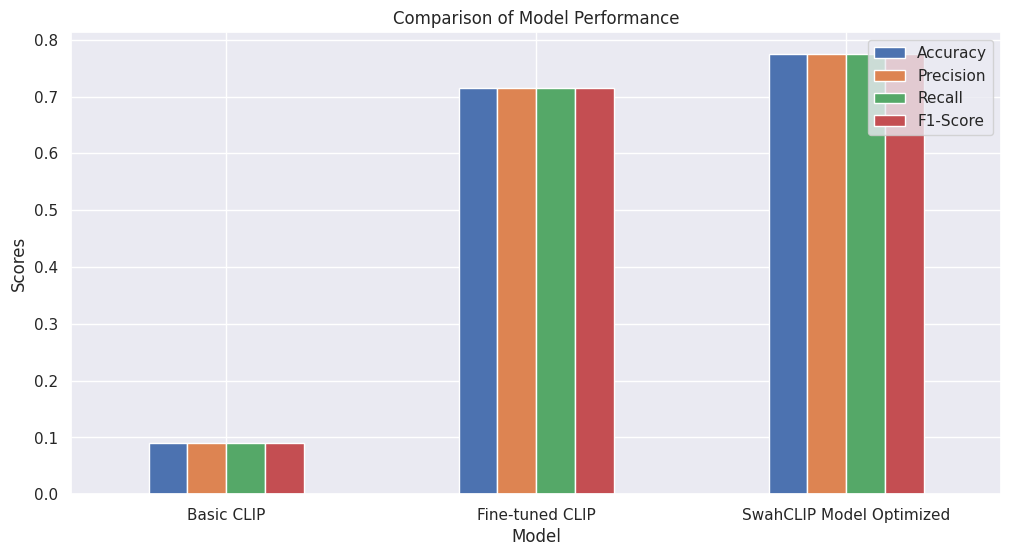

In [36]:
# Create a DataFrame to store the results
results_df = pd.DataFrame({
    "Model": ["Basic CLIP", "Fine-tuned CLIP", "SwahCLIP Model Optimized"],
    "Accuracy": [results_basic_clip["accuracy"], results_clip_finetuned["accuracy"], 
                 results_swahclip_model["accuracy"]],
    "Precision": [results_basic_clip["precision"], results_clip_finetuned["precision"], 
                  results_swahclip_model["precision"]],
    "Recall": [results_basic_clip["recall"], results_clip_finetuned["recall"], 
               results_swahclip_model["recall"]],
    "F1-Score": [results_basic_clip["f1"], results_clip_finetuned["f1"], results_swahclip_model["f1"]]
})

# Print the results DataFrame
print(results_df)

# Plot the results
plt.figure(figsize=(12, 6))
results_df.set_index("Model").plot(kind="bar", figsize=(12, 6))
plt.title("Comparison of Model Performance")
plt.ylabel("Scores")
plt.xticks(rotation=0)
plt.legend(loc="upper right")
plt.show()



In [37]:
results_df.to_csv('/kaggle/working/results_df.csv')